<a href="https://colab.research.google.com/github/shenzxc/imu/blob/main/imu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R








# 静止段检测函数
def detect_stationary(data, acc_columns, threshold=1.0):
    accel_magnitude = np.linalg.norm(data[acc_columns].values, axis=1)
    return np.abs(accel_magnitude - 9.8) < threshold

# 计算旋转矩阵函数
def compute_rotation_matrix(gravity_vector, target_vector=np.array([0, 0, 9.8])):
    if np.linalg.norm(gravity_vector) == 0:
        print("Gravity vector is zero. Using default direction.")
        gravity_vector = target_vector  # 默认方向

    gravity_vector = gravity_vector / np.linalg.norm(gravity_vector)
    target_vector = target_vector / np.linalg.norm(target_vector)

    try:
        rotation, _ = R.align_vectors([target_vector], [gravity_vector])
    except ValueError as e:
        print(f"Error in R.align_vectors: {e}")
        print("Using identity rotation as fallback.")
        rotation = R.from_matrix(np.eye(3))  # 默认单位矩阵
    return rotation


def reorient_imu(data, acc_columns, gyro_columns, rotation):
    data[acc_columns] = rotation.apply(data[acc_columns].values)
    data[gyro_columns] = rotation.apply(data[gyro_columns].values)
    return data

# 示例：重定向 IMU 数据
#file_path = 'helmet.csv'
helmet_data = pd.read_csv(file_path, sep='\t')
helmet_data.columns = bike_data.columns.str.replace(' ', '')
#helmet_data = pd.read_csv('helmet.csv')
#file_path = 'bike.csv'
bike_data = pd.read_csv(file_path, sep='\t')
bike_data.columns = bike_data.columns.str.replace(' ', '')


#
# Change the column names to match your CSV files
helmet_acc_columns = ['ax(g)', 'ay(g)', 'az(g)']  # Replace with actual column names from helmet.csv
bike_acc_columns = ['ax(g)', 'ay(g)', 'az(g)']  # Replace with actual column names from bike.csv
helmet_gyro_columns = ['wx(deg/s)', 'wy(deg/s)', 'wz(deg/s)'] # Replace with actual column names from helmet.csv
bike_gyro_columns = ['wx(deg/s)', 'wy(deg/s)', 'wz(deg/s)'] # Replace with actual column names from bike.csv


helmet_stationary = detect_stationary(helmet_data, helmet_acc_columns)
bike_stationary = detect_stationary(bike_data, bike_acc_columns)

helmet_gravity_vector = helmet_data[helmet_acc_columns][helmet_stationary].mean().values
bike_gravity_vector = bike_data[bike_acc_columns][bike_stationary].mean().values

helmet_rotation = compute_rotation_matrix(helmet_gravity_vector)
bike_rotation = compute_rotation_matrix(bike_gravity_vector)

helmet_data = reorient_imu(helmet_data, helmet_acc_columns, helmet_gyro_columns, helmet_rotation)
bike_data = reorient_imu(bike_data, bike_acc_columns, bike_gyro_columns, bike_rotation)

Error in R.align_vectors: Found zero norm quaternions in `quat`.
Using identity rotation as fallback.
Error in R.align_vectors: Found zero norm quaternions in `quat`.
Using identity rotation as fallback.


In [112]:
def align_time(data1, data2, key_column='Time(s)'):
    offset = data1[key_column].iloc[0]- data2[key_column].iloc[0]
    data2[key_column] += offset
    return data1, data2

helmet_data, bike_data = align_time(helmet_data, bike_data)


In [103]:
# 转换时间字符串为秒数
def time_to_seconds(time_str):
    try:
        h, m, s = map(float, time_str.split(':'))
        return h * 3600 + m * 60 + s
    except ValueError:
        return None  # 无效时间返回 None

helmet_data['Time(s)'] = helmet_data['Time(s)'].apply(time_to_seconds)
bike_data['Time(s)'] = bike_data['Time(s)'].apply(time_to_seconds)

# 删除无法解析的行
helmet_data.dropna(subset=['Time(s)'], inplace=True)
bike_data.dropna(subset=['Time(s)'], inplace=True)

# 时间对齐函数
def align_time(data1, data2, key_column='Time(s)'):
    offset = data1[key_column].iloc[0] - data2[key_column].iloc[0]
    data2[key_column] += offset
    return data1, data2

# 对齐时间
helmet_data, bike_data = align_time(helmet_data, bike_data)

In [64]:
bike_data.columns = bike_data.columns.str.replace(' ', '')

In [66]:
print(helmet_data.columns.tolist())

['address', 'Time(s)', 'ax(g)', 'ay(g)', 'az(g)', 'wx(deg/s)', 'wy(deg/s)', 'wz(deg/s)', 'AngleX(deg)', 'AngleY(deg)', 'AngleZ(deg)', 'Temperature(°)', 'hx', 'hy', 'hz', 'Longitude', 'Latitude', 'GPSHeight', 'GPSYaw', 'GroundVelocity', 'Pressure', 'Height']


In [113]:
def segment_data(data, segment_type):
    # 示例分割逻辑：基于速度和角速度
    if segment_type == 'straight':
        return data[data['wx(deg/s)'] < 0.1]  # 小角速度
    elif segment_type == 'turn':
        return data[data['wx(deg/s)'] > 0.1]  # 大角速度


In [115]:
helmet_data.columns = helmet_data.columns.str.strip()

# 检查缺失值并清理
helmet_data.dropna(subset=['ax(g)', 'ay(g)', 'az(g)', 'wx(deg/s)', 'wy(deg/s)', 'wz(deg/s)', 'AngleX(deg)', 'AngleY(deg)', 'AngleZ(deg)'], inplace=True)

In [116]:
def classify_motion_mode(row):
    if abs(row['ax(g)']) > 0.5:
        return 'accelerating'
    elif abs(row['ax(g)']) < 0.1 and abs(row['ay(g)']) < 0.1 and abs(row['az(g)'] - 9.8) < 0.1:
        return 'stationary'
    else:
        return 'decelerating'

In [117]:
def classify_turning_direction(row):
    if row['wy(deg/s)'] > 10:
        return 'turn_left'
    elif row['wy(deg/s)'] < -10:
        return 'turn_right'
    else:
        return 'straight'

In [118]:
def classify_observation_direction(row):
    if row['AngleY(deg)'] > 10:
        return 'look_left'
    elif row['AngleY(deg)'] < -10:
        return 'look_right'
    else:
        return 'look_forward'

In [119]:
# 应用标签生成函数
helmet_data['motion_mode'] = helmet_data.apply(classify_motion_mode, axis=1)
helmet_data['turning_direction'] = helmet_data.apply(classify_turning_direction, axis=1)
helmet_data['observation_direction'] = helmet_data.apply(classify_observation_direction, axis=1)

# 查看生成的标签
print(helmet_data[['Time(s)', 'motion_mode', 'turning_direction', 'observation_direction']].head())


   Time(s)   motion_mode turning_direction observation_direction
0  990.180  accelerating        turn_right             look_left
1  990.118  decelerating        turn_right          look_forward
2  990.218  decelerating          straight          look_forward
3  990.318  decelerating          straight          look_forward
4  990.418  decelerating        turn_right          look_forward


In [120]:
print(helmet_data['motion_mode'].value_counts())
print(helmet_data['turning_direction'].value_counts())
print(helmet_data['observation_direction'].value_counts())


motion_mode
decelerating    72441
accelerating      668
Name: count, dtype: int64
turning_direction
straight      61711
turn_left      5842
turn_right     5556
Name: count, dtype: int64
observation_direction
look_forward    63021
look_left        9586
look_right        502
Name: count, dtype: int64


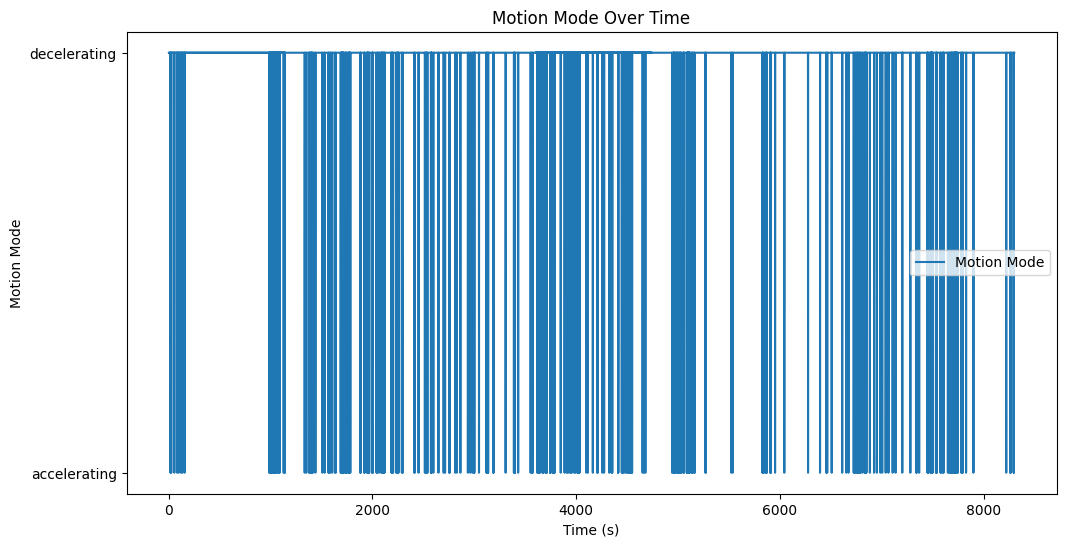

In [121]:
import matplotlib.pyplot as plt

# 绘制运动模式随时间的变化
plt.figure(figsize=(12, 6))
plt.plot(helmet_data['Time(s)'], helmet_data['motion_mode'], label='Motion Mode')
plt.xlabel('Time (s)')
plt.ylabel('Motion Mode')
plt.title('Motion Mode Over Time')
plt.legend()
plt.show()


In [122]:
helmet_data.to_csv('helmet_with_labels.csv', index=False)
print("生成的带标签数据已保存到 helmet_with_labels.csv")

生成的带标签数据已保存到 helmet_with_labels.csv


In [123]:
helmet_data['label'] = helmet_data['motion_mode']

# 分类任务
X = helmet_data[['ax(g)', 'ay(g)', 'az(g)', 'wx(deg/s)', 'wy(deg/s)', 'wz(deg/s)']]
y = helmet_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

accelerating       1.00      0.99      1.00       151
decelerating       1.00      1.00      1.00     14471

    accuracy                           1.00     14622
   macro avg       1.00      1.00      1.00     14622
weighted avg       1.00      1.00      1.00     14622



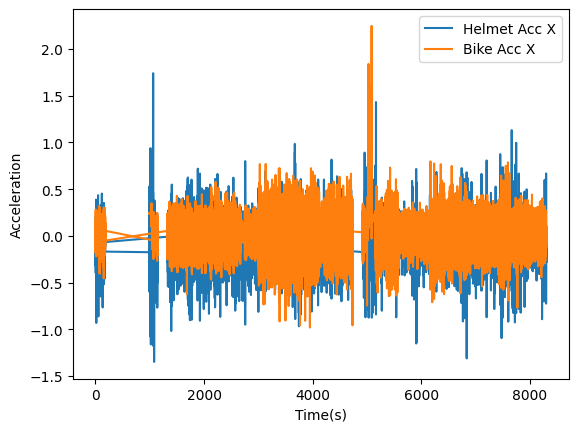

In [125]:
import matplotlib.pyplot as plt

# 绘制加速度随时间的变化
plt.plot(helmet_data['Time(s)'], helmet_data['ax(g)'], label='Helmet Acc X')
plt.plot(bike_data['Time(s)'], bike_data['ax(g)'], label='Bike Acc X')
plt.xlabel('Time(s)')
plt.ylabel('Acceleration')
plt.legend()
plt.show()